The previous part was building BIGRAM model. It works if you have single character of previous context. The predictions was not very good because of this. If we add more to previous characters, the table we use will grow up exponentially. If we take 3 chars to previous context it will be 27^3 * 27^3 table size.

Now we'll use MLP language model. In the paper, they use word level language model. Here we'll use char. level language model.

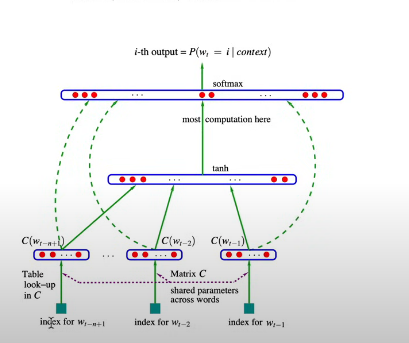

We are taking 3 previous words and predicting the 4th one. They have 17,000 words in vocabulary, every index we see here is the corresponding index in the vocab. Between 0 - 16,999 obviously. The look-up table *C* here is a matrix by 17,000 x 30. 30 here is the dimension they mentioned in the paper. Every index corresponds to a row in that C. So each index converted into a 30-dim. embedding vector that corresponds to embedding vector of that word. Here, we have 30 neurons for each 3 word (total 90 neurons).

The next step is the hidden layer (the one with the tanh function you see above.). Fully connected with the 90 neurons that come before that layer. It also applies tanh non-linearity.

In the output layer, there are 17,000 neurons corresponding to each 17,000 words that could be predicted for the 4th word given 3 words. All these are fully connected to hidden layer. So, there are 17,000 logits (raw outputs of linear layer) here. So, with softmax every logits will exponentiated and normalized to sum to 1. So we'll have a probability distribution for the next word.

All of the hyperparameters will be optimized using back-propagation.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = 3
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
X # ... 0, 0, 0
# ..e 0, 0, 5
# .em 0, 5, 13
# emm 5, 13, 13
# mma 13, 13, 1

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

### 1. EMBEDDING LOOK-UP TABLE C

Let's start with 2-dim space.

In [8]:
C = torch.randn((27, 2)) # tüm olası harfler için (a'dan z'ye) 27x2'lik bir matris oluşturduk.

In [9]:
C

tensor([[ 0.1095, -1.7738],
        [ 2.0288, -0.1467],
        [ 1.6337,  0.5824],
        [-0.4529, -0.9358],
        [ 1.6764, -0.6441],
        [-0.4986, -1.4806],
        [-0.9383,  0.8934],
        [ 1.2494,  1.6561],
        [ 1.5689, -1.0177],
        [ 0.7459,  1.0973],
        [-2.6686,  0.6140],
        [-0.0223,  0.9040],
        [ 0.6165,  0.2580],
        [ 1.1069,  0.3688],
        [-0.4505,  0.0853],
        [ 0.8592,  0.2671],
        [ 0.1990, -0.4649],
        [ 0.7564,  1.3294],
        [-0.1544, -0.4484],
        [ 0.3643,  0.7476],
        [ 0.5442,  0.3096],
        [-0.0161,  0.3691],
        [-0.9229,  0.0356],
        [ 0.5310, -0.3289],
        [-1.2022, -1.4078],
        [ 1.7333, -1.5652],
        [-0.5751, -0.2461]])

In [10]:
C[5] # 5.harf için yani e için oluşturulan random tensor.

tensor([-0.4986, -1.4806])

In [11]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C
# one-hot uygulayınca 5.eleman hariç gerisi 0 oluyor.

tensor([-0.4986, -1.4806])

In [12]:
C[X].shape # 32x3'lük X için 2-dim embedding space.

torch.Size([32, 3, 2])

In [13]:
X[13,2] # [ 0,  0,  1] yani ..a'dan a'yı çekiyor.

tensor(1)

In [14]:
C[X][13,2] # EMBEDDING OF THAT CHARACTER. a'nın embeddingi

tensor([ 2.0288, -0.1467])

In [15]:
C[1] # INTEGER AT THAT LOCATION IS EQUAL TO THIS. C matrisi 27x2 yani her harf için.
# Dolayısıyla 1.harf "a" oluyor. 0. "." idi.

tensor([ 2.0288, -0.1467])

In [16]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [17]:
emb # ... [[-0.8450,  0.6086], [-0.8450,  0.6086], [-0.8450,  0.6086]], -----> ...
# ..e [[-0.8450,  0.6086], [-0.8450,  0.6086], [-0.3989,  0.5220]], ----> ..e
# .em [[-0.8450,  0.6086], [-0.3989,  0.5220], [ 1.1298,  1.6212]] -----> .em

tensor([[[ 0.1095, -1.7738],
         [ 0.1095, -1.7738],
         [ 0.1095, -1.7738]],

        [[ 0.1095, -1.7738],
         [ 0.1095, -1.7738],
         [-0.4986, -1.4806]],

        [[ 0.1095, -1.7738],
         [-0.4986, -1.4806],
         [ 1.1069,  0.3688]],

        [[-0.4986, -1.4806],
         [ 1.1069,  0.3688],
         [ 1.1069,  0.3688]],

        [[ 1.1069,  0.3688],
         [ 1.1069,  0.3688],
         [ 2.0288, -0.1467]],

        [[ 0.1095, -1.7738],
         [ 0.1095, -1.7738],
         [ 0.1095, -1.7738]],

        [[ 0.1095, -1.7738],
         [ 0.1095, -1.7738],
         [ 0.8592,  0.2671]],

        [[ 0.1095, -1.7738],
         [ 0.8592,  0.2671],
         [ 0.6165,  0.2580]],

        [[ 0.8592,  0.2671],
         [ 0.6165,  0.2580],
         [ 0.7459,  1.0973]],

        [[ 0.6165,  0.2580],
         [ 0.7459,  1.0973],
         [-0.9229,  0.0356]],

        [[ 0.7459,  1.0973],
         [-0.9229,  0.0356],
         [ 0.7459,  1.0973]],

        [[-0.9229,  0

### 2. HIDDEN LAYER

6 is the block-size x emb. dim (3x2). 4. harf çıkarımı için önceki 3 harfi kullanıyoruz. Bu harfleri de 2-dim embedding space'e gömmüştük. 100 is the hyperparameter that we can tune.

In [18]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

The formula is emb @ W1 + b1. But what about dimensions?? Embeddings are stacked up.

In [19]:
W1.shape, b1.shape, emb.shape

(torch.Size([6, 100]), torch.Size([100]), torch.Size([32, 3, 2]))

We want retrieve the 3 words and concat. them.

In [20]:
emb[:, 0, :].shape

torch.Size([32, 2])

In [21]:
torch.cat([emb[:, 0, :], emb[:, 0, :], emb[:, 0, :]], 1).shape # along 1st dim. not 0

torch.Size([32, 6])

In [22]:
# reproducible code:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

#### An extremely efficient operation: view()

In [23]:
a = torch.arange(18) # shape is 18
a.view(9,2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [24]:
a.view(2,9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [25]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [26]:
a.view(3,2,3)

tensor([[[ 0,  1,  2],
         [ 3,  4,  5]],

        [[ 6,  7,  8],
         [ 9, 10, 11]],

        [[12, 13, 14],
         [15, 16, 17]]])

Instead of concat and other things, we can just apply view()

In [27]:
emb.shape

torch.Size([32, 3, 2])

In [28]:
emb

tensor([[[ 0.1095, -1.7738],
         [ 0.1095, -1.7738],
         [ 0.1095, -1.7738]],

        [[ 0.1095, -1.7738],
         [ 0.1095, -1.7738],
         [-0.4986, -1.4806]],

        [[ 0.1095, -1.7738],
         [-0.4986, -1.4806],
         [ 1.1069,  0.3688]],

        [[-0.4986, -1.4806],
         [ 1.1069,  0.3688],
         [ 1.1069,  0.3688]],

        [[ 1.1069,  0.3688],
         [ 1.1069,  0.3688],
         [ 2.0288, -0.1467]],

        [[ 0.1095, -1.7738],
         [ 0.1095, -1.7738],
         [ 0.1095, -1.7738]],

        [[ 0.1095, -1.7738],
         [ 0.1095, -1.7738],
         [ 0.8592,  0.2671]],

        [[ 0.1095, -1.7738],
         [ 0.8592,  0.2671],
         [ 0.6165,  0.2580]],

        [[ 0.8592,  0.2671],
         [ 0.6165,  0.2580],
         [ 0.7459,  1.0973]],

        [[ 0.6165,  0.2580],
         [ 0.7459,  1.0973],
         [-0.9229,  0.0356]],

        [[ 0.7459,  1.0973],
         [-0.9229,  0.0356],
         [ 0.7459,  1.0973]],

        [[-0.9229,  0

In [29]:
emb.view(32,6)

tensor([[ 0.1095, -1.7738,  0.1095, -1.7738,  0.1095, -1.7738],
        [ 0.1095, -1.7738,  0.1095, -1.7738, -0.4986, -1.4806],
        [ 0.1095, -1.7738, -0.4986, -1.4806,  1.1069,  0.3688],
        [-0.4986, -1.4806,  1.1069,  0.3688,  1.1069,  0.3688],
        [ 1.1069,  0.3688,  1.1069,  0.3688,  2.0288, -0.1467],
        [ 0.1095, -1.7738,  0.1095, -1.7738,  0.1095, -1.7738],
        [ 0.1095, -1.7738,  0.1095, -1.7738,  0.8592,  0.2671],
        [ 0.1095, -1.7738,  0.8592,  0.2671,  0.6165,  0.2580],
        [ 0.8592,  0.2671,  0.6165,  0.2580,  0.7459,  1.0973],
        [ 0.6165,  0.2580,  0.7459,  1.0973, -0.9229,  0.0356],
        [ 0.7459,  1.0973, -0.9229,  0.0356,  0.7459,  1.0973],
        [-0.9229,  0.0356,  0.7459,  1.0973,  2.0288, -0.1467],
        [ 0.1095, -1.7738,  0.1095, -1.7738,  0.1095, -1.7738],
        [ 0.1095, -1.7738,  0.1095, -1.7738,  2.0288, -0.1467],
        [ 0.1095, -1.7738,  2.0288, -0.1467, -0.9229,  0.0356],
        [ 2.0288, -0.1467, -0.9229,  0.0

In [30]:
h = emb.view(32,6) @ W1 + b1
h.shape

torch.Size([32, 100])

In [31]:
h = emb.view(emb.shape[0],6) @ W1 + b1
h.shape

torch.Size([32, 100])

In [32]:
h = emb.view(-1,6) @ W1 + b1
h.shape

torch.Size([32, 100])

In [33]:
h

tensor([[ 1.9465e+00, -2.3665e+00,  2.9306e-01,  ...,  3.5109e-01,
         -7.0056e+00,  4.7629e+00],
        [ 2.0026e+00, -1.8845e-01, -1.2449e-01,  ..., -4.6510e-01,
         -5.6087e+00,  5.3772e+00],
        [-8.9997e-01, -4.7853e+00, -6.8563e-01,  ...,  2.6617e+00,
         -6.4403e+00, -8.7264e-01],
        ...,
        [-3.2911e-01, -5.6320e+00,  9.6522e-01,  ...,  1.8010e+00,
         -5.2052e+00,  2.1105e-03],
        [ 3.0058e+00, -2.5658e+00,  1.8013e-01,  ..., -2.7672e-01,
         -5.9379e-01, -1.2439e+00],
        [ 2.5637e-01, -1.0014e+01,  4.3887e-01,  ...,  4.7259e-02,
         -3.4280e+00, -1.2177e+00]])

In [34]:
h = torch.tanh(h)
h

tensor([[ 0.9600, -0.9826,  0.2849,  ...,  0.3373, -1.0000,  0.9999],
        [ 0.9642, -0.1863, -0.1239,  ..., -0.4342, -1.0000,  1.0000],
        [-0.7163, -0.9999, -0.5952,  ...,  0.9903, -1.0000, -0.7027],
        ...,
        [-0.3177, -1.0000,  0.7466,  ...,  0.9469, -0.9999,  0.0021],
        [ 0.9951, -0.9883,  0.1782,  ..., -0.2699, -0.5326, -0.8466],
        [ 0.2509, -1.0000,  0.4127,  ...,  0.0472, -0.9979, -0.8390]])

### OUTPUT LAYER

In [35]:
W2 = torch.randn((100, 27)) # 27 outputs
b2 = torch.randn(27)

In [36]:
logits = h @ W2 + b2
logits

tensor([[ 2.2684e+01, -4.4292e+00, -5.5466e+00, -7.0348e-01, -8.3047e+00,
          1.8873e+01,  3.5149e+00, -3.4175e+00, -1.1756e+01,  1.2582e+01,
         -1.4613e+01, -1.2873e+01, -4.1653e-01, -1.4721e+00, -5.4276e+00,
         -1.8775e+01, -1.0986e+00, -3.1930e-01,  5.0911e+00, -3.5592e+00,
          2.8806e+00,  3.1829e+00,  2.5192e+01,  1.2477e+00, -8.4632e+00,
          7.2708e+00,  3.9612e+00],
        [ 2.2587e+01, -4.8049e+00, -5.1664e+00,  1.8920e+00, -7.7460e+00,
          2.0596e+01,  1.4689e+00, -8.2971e-01, -1.1191e+01,  1.4444e+01,
         -9.9383e+00, -1.3605e+01, -1.7634e-01, -2.6907e+00, -4.2595e+00,
         -2.0785e+01, -1.3236e-01, -3.1069e+00,  5.9853e+00,  5.7491e-01,
          3.3986e+00,  1.5805e+00,  2.5177e+01,  4.1909e-01, -1.1747e+01,
          5.0739e+00,  3.8203e+00],
        [ 1.4500e+01, -3.4260e+00,  9.3181e+00,  1.1597e+01, -8.6096e+00,
          1.4246e+01,  9.5663e+00, -7.6605e+00, -3.9724e+00, -1.1096e+01,
         -3.1274e-01, -4.6643e+00,  2.11

In [37]:
logits.shape

torch.Size([32, 27])

In [38]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [39]:
prob[0].sum()

tensor(1.)

In [40]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [41]:
prob[torch.arange(32), Y]

tensor([1.6641e-03, 7.2695e-13, 4.0297e-14, 2.7749e-07, 2.3458e-09, 7.4229e-20,
        2.1307e-08, 8.7269e-06, 2.6052e-07, 5.3469e-03, 4.0508e-12, 1.3071e-08,
        1.2619e-13, 9.9715e-01, 2.3881e-03, 2.4904e-04, 3.0832e-06, 2.8454e-11,
        8.4157e-07, 2.5053e-05, 3.0137e-08, 4.2468e-18, 5.9625e-12, 5.5300e-06,
        1.4656e-08, 3.0119e-13, 2.8220e-13, 1.5561e-10, 1.8707e-05, 1.5102e-04,
        8.5741e-09, 2.3577e-10])

Probabilities assigned by models current weight to Y values

### Negative log likelihood loss

In [42]:
loss = - (prob[torch.arange(32), Y].log().mean())
loss

tensor(18.6855)

### SUMMARY UP TO NOW

In [43]:
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [44]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [45]:
sum(p.nelement() for p in parameters) # total num. of parameters

3481

In [46]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2

In [47]:
%%time

counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True) # prob. distribution
loss = - prob[torch.arange(X.shape[0]), Y].log().mean() # mapped indices to prob. dist.
loss

CPU times: total: 0 ns
Wall time: 1 ms


tensor(17.7697)

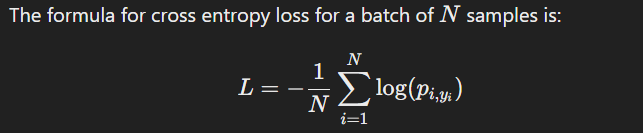

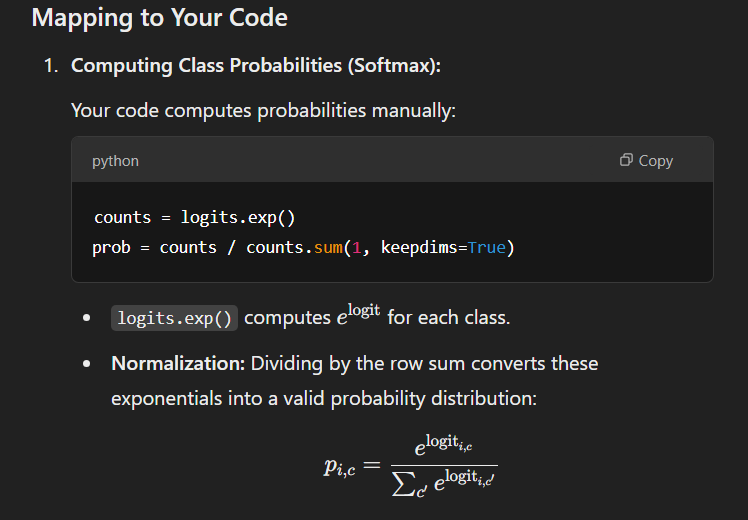

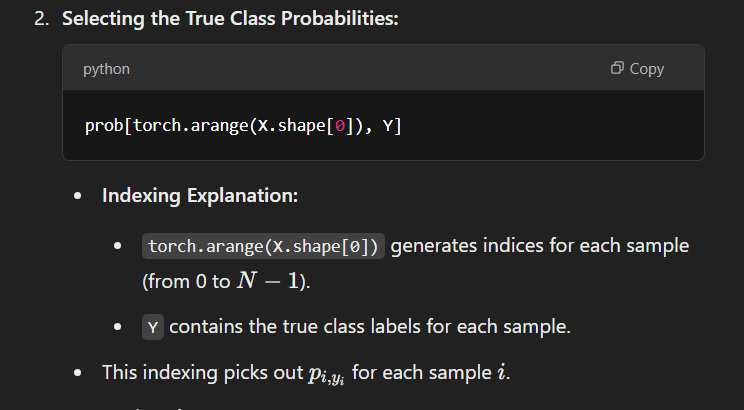

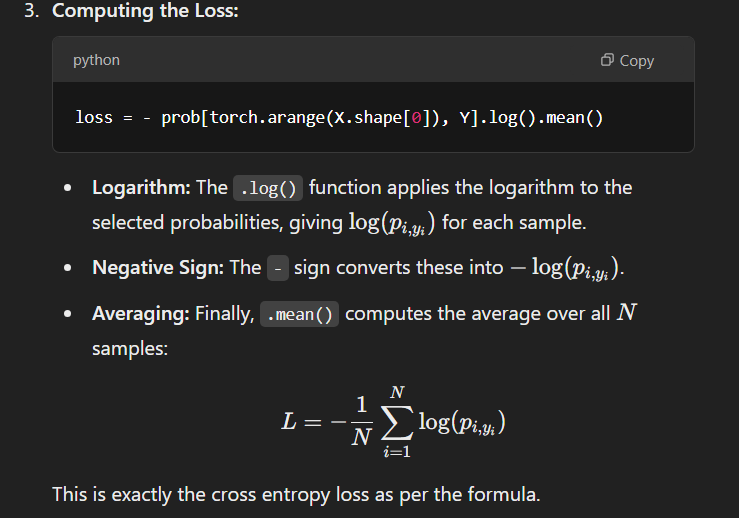

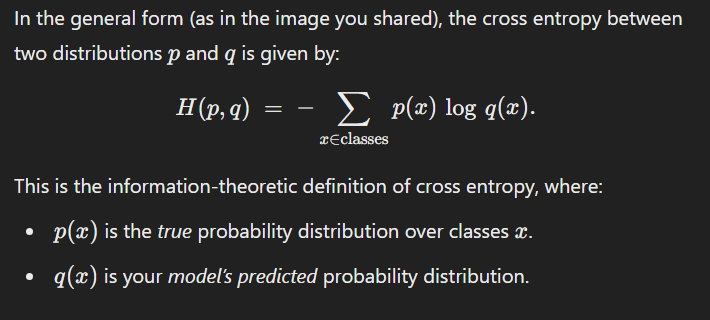

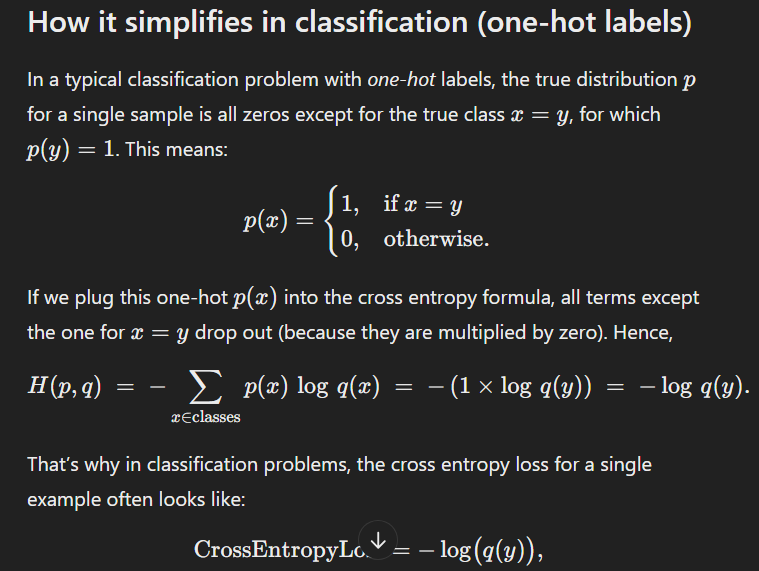

### To calculate this much more efficiently

In [48]:
%%time

loss = F.cross_entropy(logits, Y)
loss

CPU times: total: 0 ns
Wall time: 10 ms


tensor(17.7697)

### TRAINING OF THE NEURAL NET

In [49]:
for _ in range(10):
    
    ### FORWARD PASS
    emb = C[X] # 32x3x2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32x100
    logits = h @ W2 + b2 # 32x27
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    
    ### BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -0.1 * p.grad

17.76971435546875


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

To resolve the error:

In [50]:
for p in parameters:
    p.requires_grad = True
for _ in range(10):
    
    ### FORWARD PASS
    emb = C[X] # 32x3x2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32x100
    logits = h @ W2 + b2 # 32x27
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    
    ### BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -0.1 * p.grad

17.76971435546875
13.656400680541992
11.298768997192383
9.452457427978516
7.984262466430664
6.891322135925293
6.100014686584473
5.452037334442139
4.8981523513793945
4.414664268493652


In [51]:
logits.max(1)

torch.return_types.max(
values=tensor([10.7865, 12.2558, 17.3982, 13.2739, 10.6965, 10.7865,  9.5145,  9.0495,
        14.0280, 11.8378,  9.9038, 15.4187, 10.7865, 10.1476,  9.8372, 11.7660,
        10.7865, 10.0029,  9.2940,  9.6824, 11.4241,  9.4885,  8.1164,  9.5176,
        12.6383, 10.7865, 10.6021, 11.0822,  6.3617, 17.3157, 12.4544,  8.1669],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1,  8,  9,  0, 15,  1, 17,  2,  9,  9,  2,  0,  1, 15,  1,  0,  1, 19,
         1,  1, 16, 10, 26,  9,  0,  1, 15, 16,  3,  9, 19,  1]))

In [52]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

Burada aldığımız loss aslında overfit ediyor. Çünkü baktığımızda 32 tane example var ve 3000'den fazla parametre (W, b) var.

Ancak,

Loss hiçbir zaman 0.0 olamaz. Çünkü görüldüpü gibi, ...'dan sonra hem a, hem i hem s vs. vs. gelebilir. Bu nedenle yukarıdaki gibi onu tahmin etmek zordur (yukarıdaki Y ve logits.max(1)'in ilk indisine bakarsak biri 5 biri 1.).

### TRAINING ON THE FULL DATASET, MINIBATCHES

In [53]:
block_size = 3
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [54]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [55]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [56]:
sum(p.nelement() for p in parameters)

3481

In [57]:
for p in parameters:
    p.requires_grad = True

In [58]:
for _ in range(10):
    
    ### FORWARD PASS
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    ### BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()

    ### UPDATE
    for p in parameters:
        p.data += -0.1 * p.grad


19.505229949951172
17.084487915039062
15.776531219482422
14.833340644836426
14.002604484558105
13.253260612487793
12.57991886138916
11.983101844787598
11.47049331665039
11.05185604095459


*--------------------------------------------------------------------*

Normally this will take too much time. So, instead of forward and backward passing all the data, we use randomly selected mini-batches and update them.

#### mini batch training

In [59]:
torch.randint(0, X.shape[0], (32,))

tensor([ 89699,  32677, 187790,   4497, 191493,  46522, 158345,  40444, 131152,
        133285,  61775,  96143,  66108, 215211,  30692,  10604,  96280,  93202,
         31691, 208872,  95482, 197789, 105274,   3341, 107858, 196151,  44584,
        166997,  98351, 214434,  18378,  41628])

In [60]:
for p in parameters:
    p.requires_grad = True
    
for _ in range(10):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))
    
    ### FORWARD PASS
    emb = C[X][ix]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    ### BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()

    ### UPDATE
    for p in parameters:
        p.data += -0.1 * p.grad


7.5994157791137695
10.828627586364746
8.387358665466309
9.54576301574707
10.946537017822266
11.232321739196777
10.12647819519043
8.647663116455078
9.284770011901855
8.60020637512207


Because we are using only 32 examples, the gradient direction is not reliable, quality is lower, but it is good enough.

### DETERMINING LEARNING RATE

Right now, we are using learning rate as 0.1, but can we do better?

In [61]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [62]:
for p in parameters:
    p.requires_grad = True

In [63]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [64]:
lri = []
lossi = []

for i in range(1000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))
    
    ### FORWARD PASS
    emb = C[X][ix]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    ### BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()

    ### UPDATE
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    ### TRACK STATS
    lri.append(lre[i])
    lossi.append(loss.item())


20.76995849609375
15.502156257629395
16.46230125427246
18.473966598510742
22.28791618347168
18.184022903442383
22.11728286743164
16.535446166992188
19.343320846557617
17.318485260009766
16.81805992126465
17.40822982788086
17.533931732177734
19.51258659362793
20.988994598388672
20.674930572509766
17.418210983276367
23.67148208618164
17.92734146118164
17.391569137573242
19.922630310058594
19.31768226623535
17.27473258972168
18.68111801147461
17.434579849243164
20.773944854736328
17.588714599609375
18.39629364013672
16.756256103515625
20.047561645507812
18.08517837524414
18.259967803955078
21.130020141601562
16.656139373779297
17.06169319152832
18.401262283325195
16.866697311401367
15.134714126586914
19.773427963256836
18.43435287475586
18.097454071044922
18.616802215576172
15.915732383728027
18.80803108215332
17.421066284179688
21.294063568115234
17.028379440307617
15.058579444885254
16.645397186279297
15.994736671447754
20.244617462158203
19.05893325805664
18.84267234802246
17.277153015

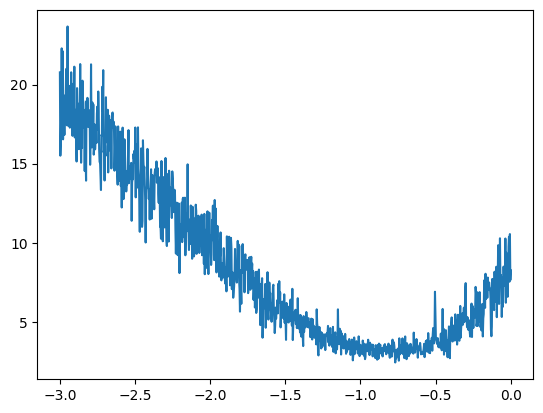

In [65]:
plt.plot(lri, lossi) # x, y axis

The x axis is the learning rate exponents. -1.0 looks good, and because lr = 10^lre, 10^-1 = 0.1 So, we can set learning rate to be 0.1. This looks good on the plot.

So, we can start with 0.1 learning rate, train with that, and then we can apply weight decay, say to 0.01, and continue to training.

### SPLITTING UP THE DATASET INTO TRAIN/VAL/TEST SPLITS

In [67]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr =  build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [68]:
len(words)

32033

In [69]:
n1

25626

In [70]:
n2

28829

In [71]:
n2-n1

3203

In [72]:
len(words)-n2

3204

### Training

In [75]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [91]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [W1, b1, W2, b2]

In [92]:
sum(p.nelement() for p in parameters)

3427

In [93]:
for p in parameters:
    p.requires_grad = True

In [94]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [97]:
lri = []
lossi = []

for i in range(10000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 3)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1
    for p in parameters:
        p.data += - lr * p.grad
        

In [98]:
print(loss.item())

2.344165325164795


In [100]:
emb = C[Xtr] # (32, 3, 3)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4907, grad_fn=<NllLossBackward0>)

In [99]:
emb = C[Xdev] # (32, 3, 3)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4896, grad_fn=<NllLossBackward0>)

### EXPERIMENT WITH LARGER HIDDEN LAYERS

Our model is underfitting. To get rid of underfitting, we can use larger layers. 

In [113]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [W1, b1, W2, b2]

In [114]:
sum(p.nelement() for p in parameters)

10227

In [115]:
for p in parameters:
    p.requires_grad = True

In [116]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [117]:
lri = []
lossi = []
stepi = []

for i in range(30000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 3)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1
    for p in parameters:
        p.data += - lr * p.grad

    stepi.append(i)
    lossi.append(loss.item())
        

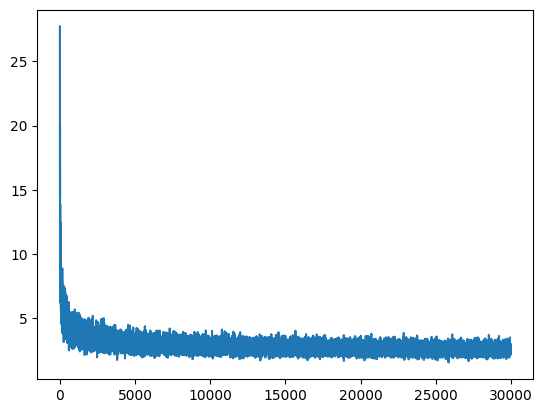

In [118]:
plt.plot(stepi, lossi)

We see some thickness in the plot. That's because of mini-batches, they create a bit of noise.

In [119]:
emb = C[Xtr] # (32, 3, 3)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.5540, grad_fn=<NllLossBackward0>)

In [120]:
emb = C[Xdev] # (32, 3, 3)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5864, grad_fn=<NllLossBackward0>)